In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets (replace paths with your actual file paths)
resumes = pd.read_csv("resumes.csv")  # Resume dataset: columns = ["Category", "Resume"]
jobs = pd.read_csv("jobs.csv")  # Job dataset: columns = ["Job Title", "Company", "Description", "Language"]

# Filter the jobs to only include English rows
jobs = jobs[jobs["Language"] == "en"]


In [4]:
# Preprocessing: Combine resume columns (if needed) and clean text
def preprocess_text(text):
    # Convert to lowercase, remove special characters, extra spaces
    text = str(text).lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

resumes["Resume"] = resumes["Resume"].apply(preprocess_text)
jobs["Description"] = jobs["Description"].apply(preprocess_text)


In [5]:
# Combine text from resumes and job descriptions for TF-IDF vectorization
all_text = pd.concat([resumes["Resume"], jobs["Description"]])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Split TF-IDF Matrix back into resumes and jobs
resume_vectors = tfidf_matrix[:len(resumes)]
job_vectors = tfidf_matrix[len(resumes):]


In [6]:
# Calculate Cosine Similarity
cosine_similarities = cosine_similarity(resume_vectors, job_vectors)


In [7]:
# Match resumes with jobs
matches = []
category_job_matches = []
for i, resume in resumes.iterrows():
    similar_jobs_indices = cosine_similarities[i].argsort()[-3:][::-1]  # Top 3 matches
    similar_jobs = jobs.iloc[similar_jobs_indices]
    matches.append({
        "Resume": resume["Resume"],
        "Top_Matched_Jobs": similar_jobs["Job Title"].tolist(),
        "Similarities": cosine_similarities[i, similar_jobs_indices].tolist()
    })
    # Save Resume Category and Top Matched Job Title
    category_job_matches.append({
        "Resume_Category": resume["Category"],
        "Top_Matched_Job": similar_jobs["Job Title"].iloc[0]  # Best match
    })


In [8]:
# Convert matches to DataFrames
matches_df = pd.DataFrame(matches)
category_job_matches_df = pd.DataFrame(category_job_matches)


In [9]:

# Save results to CSV files
matches_df.to_csv("resume_job_matches_en.csv", index=False)
category_job_matches_df.to_csv("resume_category_job_matches_en.csv", index=False)


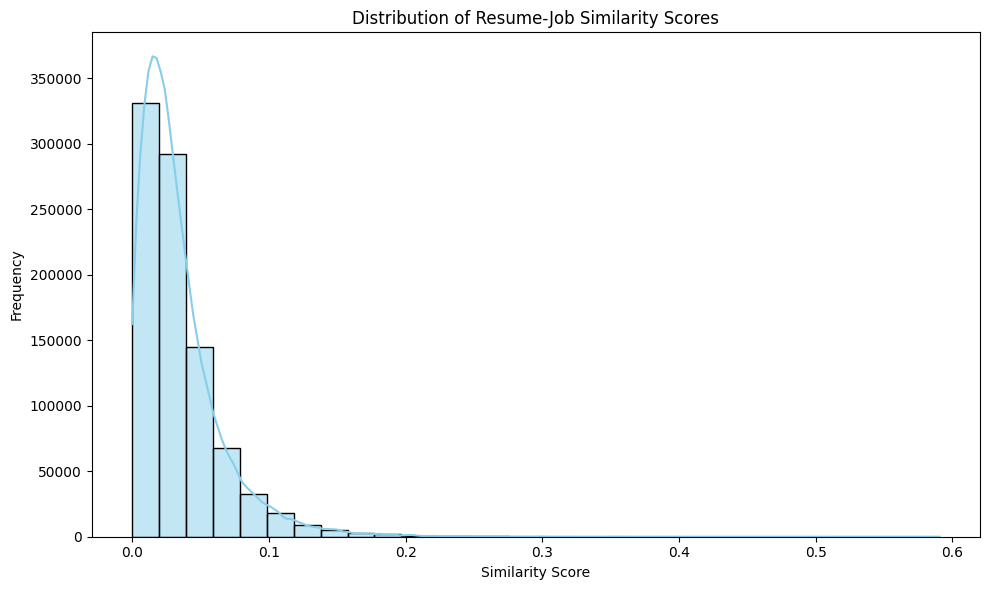

In [10]:
# Visualization
# 1. Distribution of Similarity Scores
all_similarities = cosine_similarities.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(all_similarities, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Resume-Job Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


C:\Users\imane\AppData\Local\Temp\ipykernel_14668\107819236.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


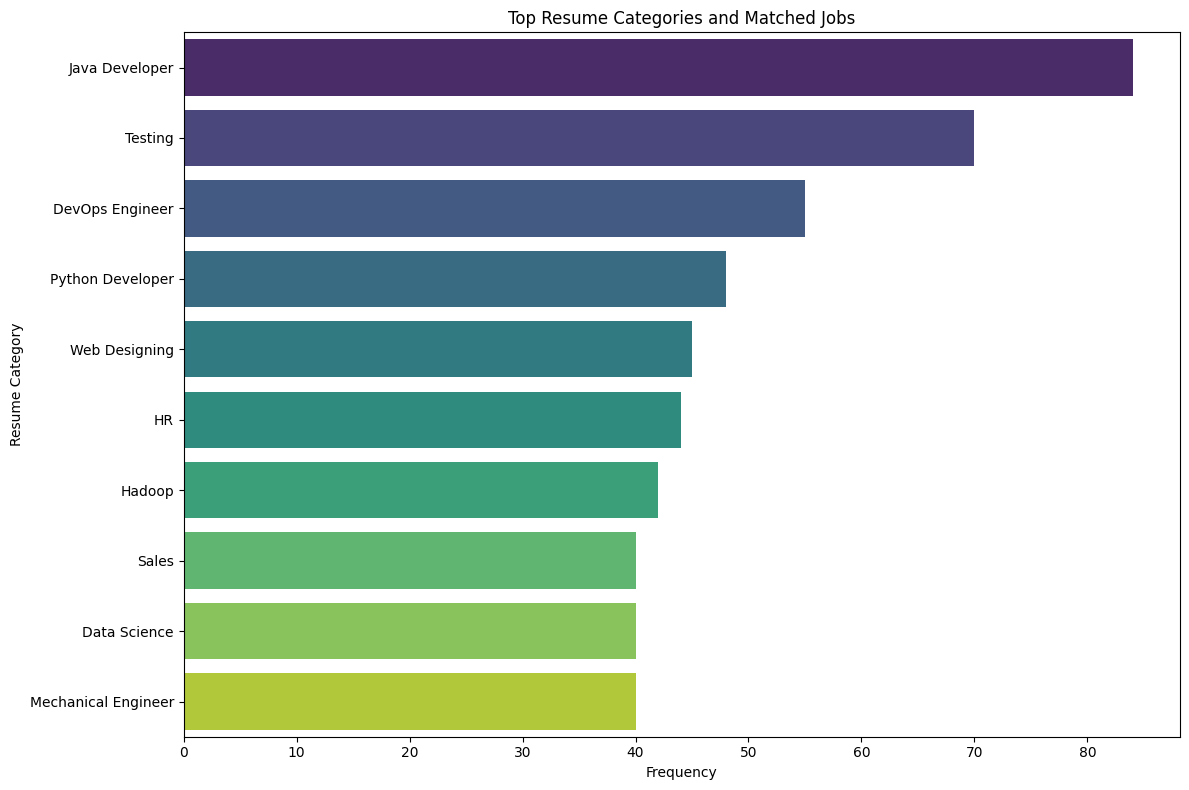

In [11]:
# 2. Top Categories and Matched Jobs
top_categories = category_job_matches_df["Resume_Category"].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top Resume Categories and Matched Jobs")
plt.xlabel("Frequency")
plt.ylabel("Resume Category")
plt.tight_layout()
plt.show()


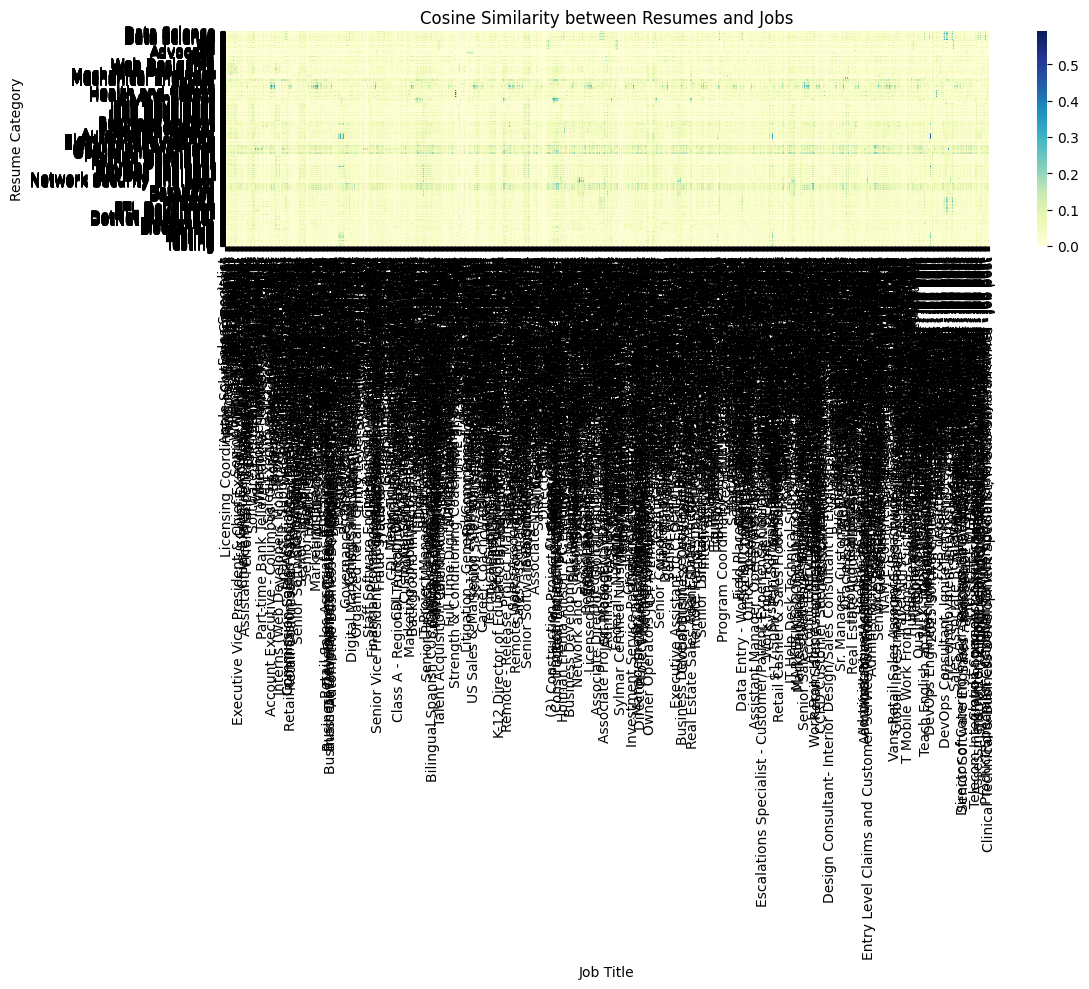

In [12]:
# Visualization 3: Heatmap of Cosine Similarity between Resumes and Jobs
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_similarities, cmap="YlGnBu", annot=False, fmt=".2f", xticklabels=jobs["Job Title"], yticklabels=resumes["Category"])
plt.title("Cosine Similarity between Resumes and Jobs")
plt.xlabel("Job Title")
plt.ylabel("Resume Category")
plt.tight_layout()
plt.show()


C:\Users\imane\AppData\Local\Temp\ipykernel_14668\1335008304.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_jobs.values, y=top_n_jobs.index, palette="magma")


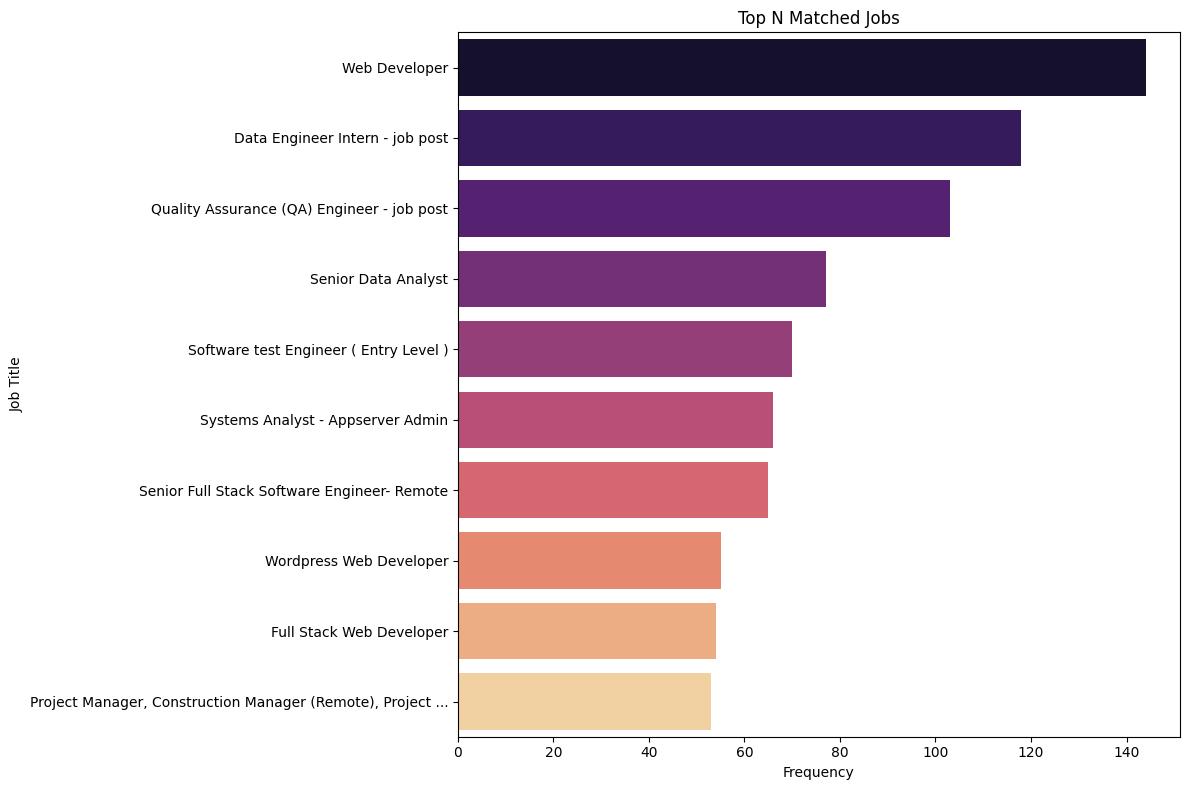

In [13]:
# Visualization 4: Top N Similar Jobs per Resume
top_n_jobs = matches_df.explode("Top_Matched_Jobs")["Top_Matched_Jobs"].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_n_jobs.values, y=top_n_jobs.index, palette="magma")
plt.title("Top N Matched Jobs")
plt.xlabel("Frequency")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

In [14]:
# Visualization 5: Correlation Matrix of Cosine Similarity Scores
# correlation_matrix = pd.DataFrame(cosine_similarities).corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
# plt.title("Correlation Matrix of Resume-Job Cosine Similarity Scores")
# plt.tight_layout()
# plt.show()


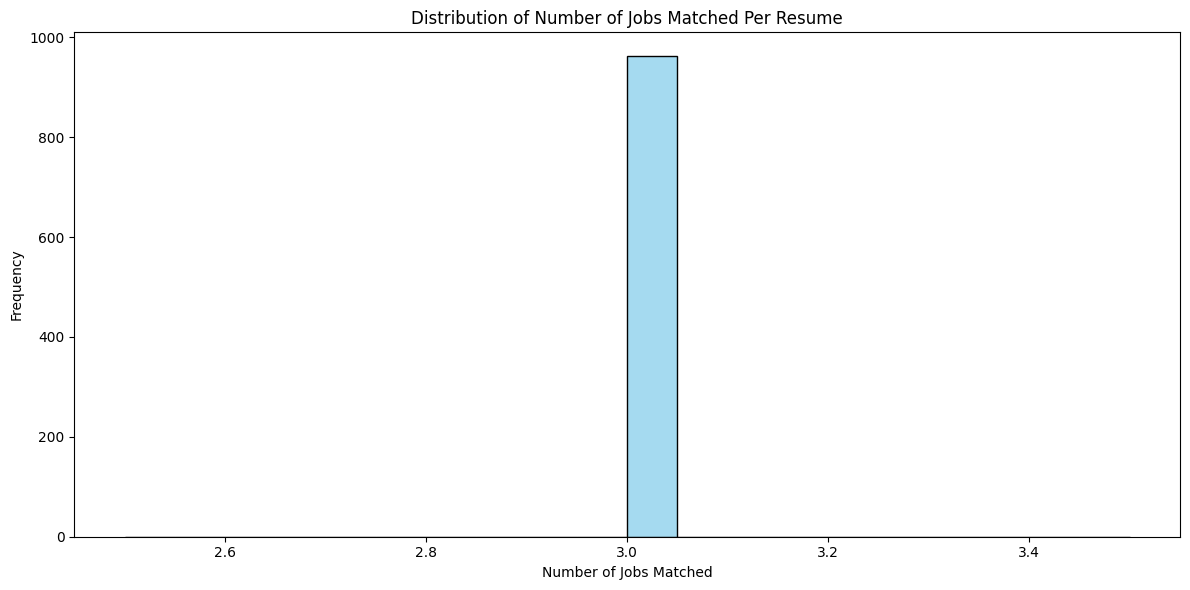

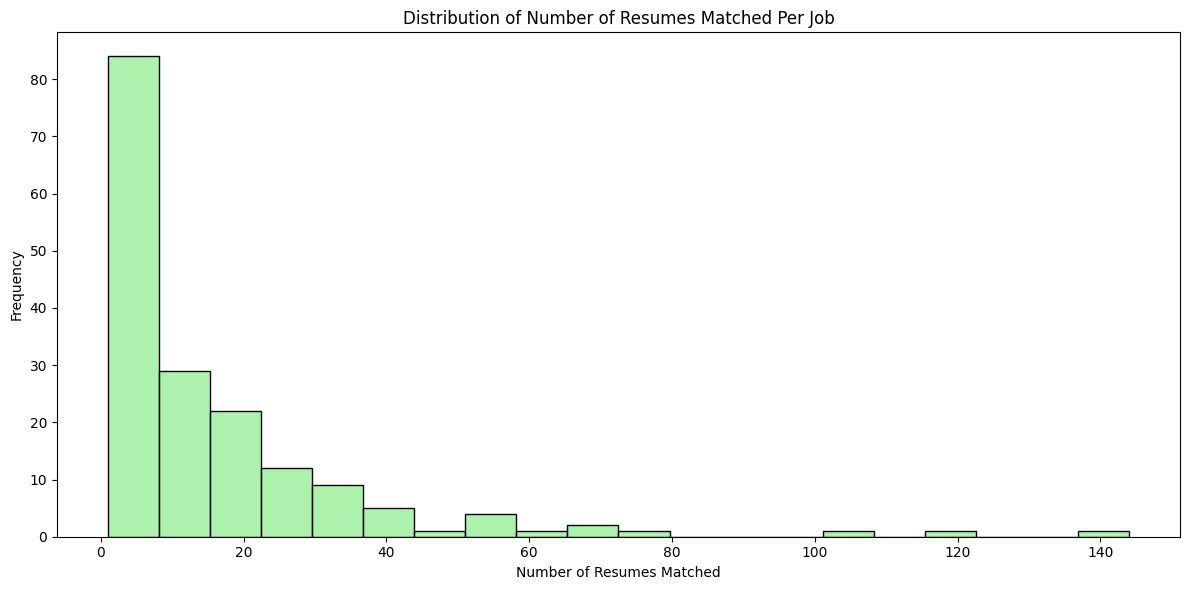

C:\Users\imane\AppData\Local\Temp\ipykernel_14668\3496190810.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


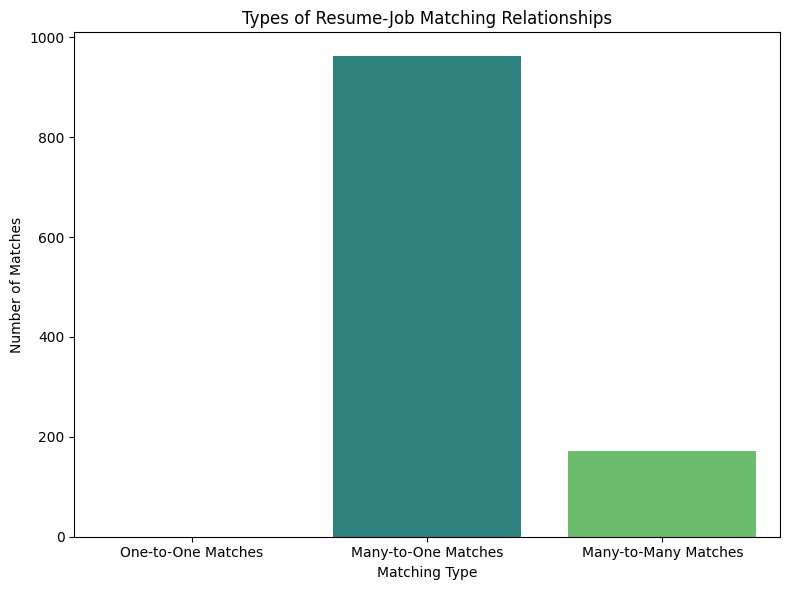

In [15]:
# 1. Count how many jobs each resume is matched with (Top N matches)
resumes_match_count = matches_df["Top_Matched_Jobs"].apply(len)  # Number of matched jobs per resume

# 2. Count how many resumes each job is matched with
job_match_count = matches_df["Top_Matched_Jobs"].explode().value_counts()  # Number of resumes per job

# Visualization 1: Number of Jobs Matched Per Resume
plt.figure(figsize=(12, 6))
sns.histplot(resumes_match_count, kde=False, bins=20, color='skyblue')
plt.title("Distribution of Number of Jobs Matched Per Resume")
plt.xlabel("Number of Jobs Matched")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Visualization 2: Number of Resumes Matched Per Job
plt.figure(figsize=(12, 6))
sns.histplot(job_match_count, kde=False, bins=20, color='lightgreen')
plt.title("Distribution of Number of Resumes Matched Per Job")
plt.xlabel("Number of Resumes Matched")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Visualization 3: Relationship Between Resumes and Jobs (One-to-One, Many-to-One, Many-to-Many)
# If each resume has only one match, it will be a perfect one-to-one match
# We can analyze the proportion of "one-to-one" vs "many-to-one" or "many-to-many" matches

one_to_one_count = len(resumes_match_count[resumes_match_count == 1])
many_to_one_count = len(resumes_match_count[resumes_match_count > 1])
many_to_many_count = len(job_match_count[job_match_count > 1])

# Bar plot showing the type of matching relationships
plt.figure(figsize=(8, 6))
sns.barplot(
    x=["One-to-One Matches", "Many-to-One Matches", "Many-to-Many Matches"],
    y=[one_to_one_count, many_to_one_count, many_to_many_count],
    palette="viridis"
)
plt.title("Types of Resume-Job Matching Relationships")
plt.xlabel("Matching Type")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()
